<a href="https://colab.research.google.com/github/babypanda212/mless/blob/main/remote_sensing/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1: CNN vs ResNet on SAT-6 Dataset

## Table of Contents

1. **Imports**
2. **SkipLayer**
    - **Implementation**  
    - **Test**  
3. Dataset Preparation
    - **Download SAT-6 Dataset**
    - **Dataset Exploration**
    - **Dataset Preprocessing**
4. Model Architectures
    - **Vanilla CNN**
    - **Torchvision ResNet18 (Modified)**
5. Training Pipelines
    - **Training the Vanilla CNN**
    - **Training ResNet18**
6. Evaluation
    - **Predictions on Test Dataset**
    - **Evaluate Vanilla CNN**
    - **Evaluate ResNet18**
7. Observations


# Imports

In [1]:
# import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, cohen_kappa_score, roc_curve
from tqdm import tqdm
import torch.nn.functional as F
from torchvision.models import resnet18

# SkipLayer
## Implementation

In [2]:
## Write a torch module for one skip layer as shown in the figure below

## A layer in the figure represent a sequential layer of conv layer -> batchnorm -> Activation function(ReLu)

## We expect by now, you have learnt about different arguments of torch.nn.Conv2D module like in_channels, out_channels, kernel_size, stride, and padding

##import modules whichever required

class SkipLayer(torch.nn.Module):
  def __init__(self) -> None:
    super().__init__()

    # Define the layers as shown in the figure

    # Define conv layer
    self.conv = torch.nn.Conv2d(in_channels=4, out_channels=4, kernel_size=3, stride=1, padding=1)
    # Define batchnorm layer
    self.bn = torch.nn.BatchNorm2d(num_features=4)

  def forward(self,x):
    # Implement the forward pass as shown in the figure
    # Apply conv layer, batchnorm, and relu activation
    out = self.conv(x)
    out = self.bn(out)
    out = F.relu(out)
    # Add the input x to the output - this is the skip connection
    out = out + x
    return out

## Test

In [3]:
## Test your module

# 16-batchsize
# 4-channels
# 28 \times 28 - height \times width

random_sample = torch.randn((16,4,28,28))
skip_layer = SkipLayer()
print(skip_layer(random_sample).shape)

torch.Size([16, 4, 28, 28])


# Dataset Preparation
## Download SAT-6 Dataset

In [4]:
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
!wget https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/sat6annotations.csv

--2025-06-02 13:35:44--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/X_test_sat6.csv
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 905628829 (864M) [text/plain]
Saving to: ‘X_test_sat6.csv’

X_test_sat6.csv     100%[===================>] 863.67M  19.8MB/s    in 44s     

2025-06-02 13:36:29 (19.6 MB/s) - ‘X_test_sat6.csv’ saved [905628829/905628829]

--2025-06-02 13:36:30--  https://b2share.eudat.eu/api/files/a697daf7-7570-44ff-854c-0fab43f2b52c/y_test_sat6.csv
Resolving b2share.eudat.eu (b2share.eudat.eu)... 86.50.166.97
Connecting to b2share.eudat.eu (b2share.eudat.eu)|86.50.166.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 972000 (949K) [text/plain]
Saving to: ‘y_test_sat6.csv’

y_test_sat6.csv     100%[===================>] 949.22K  1.13MB/s    in 0.8s    

2025-06-02 13:36

## Dataset Exploration

In [5]:
# load the csv file with the image data. Each row belongs to one sample. Each sample has 3136 columns i.e. 4 channels (R,G,B, and NIR) and 28 \times 28 spatial size
landcover_df = pd.read_csv("./X_test_sat6.csv",header=None)
landcover_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3096,3097,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109,3110,3111,3112,3113,3114,3115,3116,3117,3118,3119,3120,3121,3122,3123,3124,3125,3126,3127,3128,3129,3130,3131,3132,3133,3134,3135
0,95,91,61,157,105,113,101,179,50,35,24,124,117,129,127,188,95,105,94,161,45,39,24,110,65,71,81,115,51,56,66,94,52,59,65,84,49,50,58,90,...,61,56,34,102,95,106,97,145,93,102,75,150,121,137,124,196,114,131,113,196,82,90,55,164,90,101,69,166,107,122,107,181,118,137,127,205,90,105,86,183
1,102,102,103,137,108,110,116,154,88,83,70,122,81,69,53,103,96,92,85,140,134,142,150,205,110,111,106,174,104,97,85,155,104,98,85,154,99,95,81,148,...,113,110,93,168,115,114,95,171,115,115,96,177,125,127,113,195,126,130,119,199,127,131,124,199,124,126,120,191,101,99,91,157,95,92,84,143,89,85,76,130
2,47,54,95,10,79,89,108,15,96,131,118,23,96,130,124,24,74,96,124,17,78,82,122,19,123,128,139,34,145,163,154,49,139,153,159,49,136,143,159,42,...,154,148,155,60,97,103,130,26,70,63,121,15,81,86,127,17,76,81,126,15,50,48,105,10,51,56,107,11,69,100,118,17,82,98,125,18,61,69,113,13
3,200,181,178,218,192,177,176,214,162,141,125,196,157,132,112,192,161,138,122,195,197,183,180,211,216,205,200,220,219,208,202,222,212,200,189,216,207,193,180,213,...,148,125,107,187,139,118,93,182,155,139,117,196,159,141,124,197,165,142,129,201,145,121,102,188,155,138,118,194,168,152,139,203,157,138,125,193,147,128,107,187
4,85,101,100,15,87,102,97,16,54,71,88,10,29,34,78,7,42,55,75,8,51,79,76,8,41,56,76,7,31,37,75,6,30,51,74,6,30,44,71,5,...,34,46,71,6,26,38,72,5,24,34,68,5,24,37,66,5,31,44,70,6,49,73,77,8,54,82,79,9,50,54,74,8,37,49,76,6,27,43,69,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80995,82,82,115,17,104,123,131,23,100,119,139,22,80,104,129,15,63,44,117,10,48,49,114,9,45,59,112,9,68,81,124,14,108,107,136,23,137,160,138,38,...,69,84,117,15,64,81,114,13,56,77,115,12,70,69,121,14,100,93,130,21,119,110,140,26,120,99,141,27,115,109,146,32,137,152,159,44,159,166,166,61
80996,170,148,147,174,203,188,163,190,211,197,173,196,215,204,178,196,216,208,182,192,212,203,177,185,206,194,170,178,202,188,166,176,200,186,163,177,195,179,161,176,...,164,157,135,180,162,155,130,181,161,154,136,179,164,154,139,175,160,151,134,172,147,146,135,172,139,145,137,173,147,149,134,172,163,154,136,175,172,157,143,177
80997,140,136,126,190,156,163,152,208,152,170,149,205,94,84,56,139,63,44,45,111,80,69,58,111,118,118,126,158,106,103,93,147,139,147,144,189,88,80,43,135,...,76,78,66,122,72,73,56,128,89,91,79,152,102,116,106,175,105,120,113,179,74,71,59,149,72,71,44,130,104,120,126,162,93,111,119,170,68,66,61,123
80998,89,87,99,13,64,66,89,9,16,26,65,4,12,24,60,4,14,23,62,4,16,27,63,4,23,32,71,5,40,46,84,8,44,64,82,7,26,47,75,5,...,39,48,84,7,14,29,70,5,17,28,74,4,29,30,79,6,65,74,95,10,97,101,109,18,92,121,122,22,59,91,111,15,49,52,97,11,47,56,102,9


### Read annotation labels from different csv file

In [6]:
# Read the annotation file to get the annotation i.e. classname corresponding to the labels
annotations = pd.read_csv("./sat6annotations.csv", header=None)
print(annotations)
labels = annotations[0].values
print(f'class labels: {labels}')

             0  1  2  3  4  5  6
0     building  1  0  0  0  0  0
1  barren_land  0  1  0  0  0  0
2        trees  0  0  1  0  0  0
3    grassland  0  0  0  1  0  0
4         road  0  0  0  0  1  0
5        water  0  0  0  0  0  1
class labels: ['building' 'barren_land' 'trees' 'grassland' 'road' 'water']


**Reminder :**  The data structure that you see above is called _one-hot encoding_


In [7]:
# load the csv file with the labels of all samples
labels_df = pd.read_csv("./y_test_sat6.csv",header=None)
print(labels_df)
# get the names of the class labels (here, only "0" to "5")
# These correspond to the labels printed above
column_names = labels_df.columns.values

       0  1  2  3  4  5
0      0  0  1  0  0  0
1      0  0  1  0  0  0
2      0  0  0  0  0  1
3      0  1  0  0  0  0
4      0  0  0  0  0  1
...   .. .. .. .. .. ..
80995  0  0  0  0  0  1
80996  0  1  0  0  0  0
80997  0  0  1  0  0  0
80998  0  0  0  0  0  1
80999  0  0  1  0  0  0

[81000 rows x 6 columns]


### Plot random samples for illustration
Plot few samples to see visually the data and gain more insights on how to reshape the 1d data to a 4 channel image (RGB & NIR)

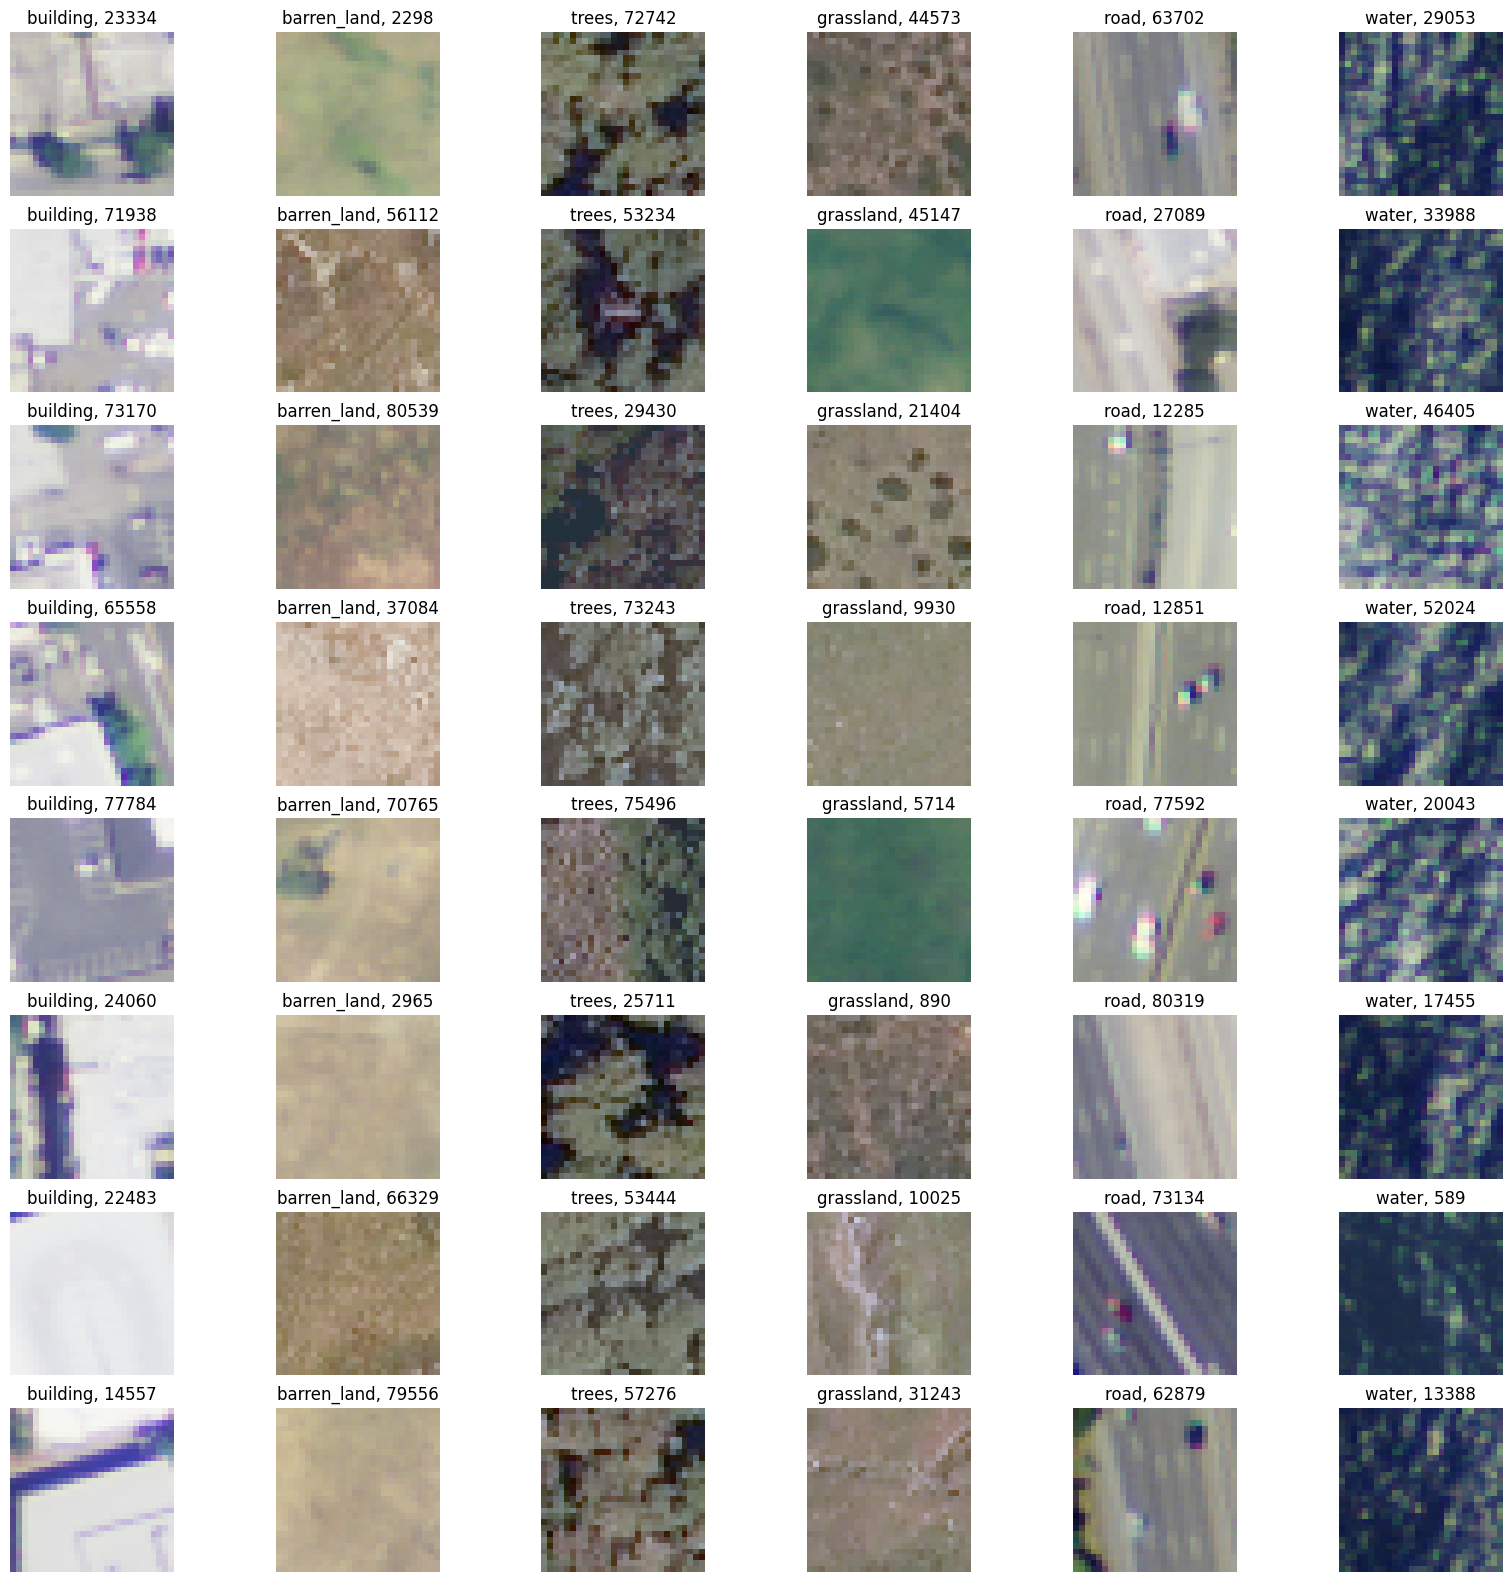

In [8]:
num_classes = len(column_names)
num_samples = 8  # number of rows to plot
sample_idx = []
for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1
    # randomly select num_samples from this index list - make sure to avoid duplicates
    sample_idx.append(np.random.choice(np.where(class_idx.values)[0], size=num_samples, replace=False).tolist())

fig, ax = plt.subplots(num_samples, num_classes, figsize=(20,20))
for i in range(num_samples):
    for j in range(num_classes):
        data_index = sample_idx[j][i]
        ax[i,j].set_title(f"{labels[j]}, {data_index}")
        ax[i,j].axis('off')
        data = np.reshape(landcover_df.iloc[data_index].values,(-1,28,28,4))
        ax[i,j].imshow(data[0,...,:3])

## Dataset Preprocessing

### Create the training and test datasets

In [9]:
num_train = 1000 #replace with -1 if all samples need to be used for training
num_test = 100
train_idx = []
test_idx = []
for column in column_names:
    # find all indices of a given class
    class_idx = labels_df[column] == 1
    # randomly select num_train and num_test values from this index list - make sure to avoid duplicates
    valid_indices = np.where(class_idx.values)[0]
    random_indices = np.random.permutation(valid_indices)
    test_idx.extend(random_indices[:num_test])
    train_idx.extend(random_indices[num_test:num_test+num_train if num_train != -1 else num_train])
print(f'number of train indices: {len(train_idx)}, number of test indices: {len(test_idx)}')


number of train indices: 6000, number of test indices: 600


In [10]:
# Extract images and labels corresponding to the selected indices
train_X = landcover_df.iloc[train_idx]
train_y = labels_df.iloc[train_idx]
test_X = landcover_df.iloc[test_idx]
test_y = labels_df.iloc[test_idx]

### Calculate Normalization Parameter using Train Dataset

In [11]:
train_X_reshape = train_X.values.reshape((-1,28,28,4))
mean_per_channels = np.mean(train_X_reshape,axis=(0,1,2)).astype(np.float32)
std_per_channels = np.std(train_X_reshape,axis=(0,1,2)).astype(np.float32)
mean_per_channels, std_per_channels

(array([132.06001, 132.02974, 129.3226 , 120.37813], dtype=float32),
 array([55.61186 , 51.102043, 46.866848, 66.038376], dtype=float32))

### Define torch dataset

In [12]:
class SAT6Dataset(Dataset):
  def __init__(self,data_df,label_df, normalization_parameter):
    super(SAT6Dataset,self).__init__()
    self.data_df = data_df
    self.label_df = label_df
    self.normalization = normalization_parameter

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self,idx):
    data = self.data_df.iloc[idx].values.reshape((28,28,4)).astype(np.float32)
    data = (data-self.normalization[0])/self.normalization[1]
    #data = data/255.0
    data = np.transpose(data,axes=(2,0,1))
    label = self.label_df.iloc[idx].values
    label_args = np.where(label==1)[0]

    return (data,label_args[0])

In [13]:
# define two dataset one for train and other for test
sat6_train_dataset = SAT6Dataset(train_X,train_y,(mean_per_channels,std_per_channels))
sat6_test_dataset = SAT6Dataset(test_X,test_y,(mean_per_channels,std_per_channels))

# Model Architectures


## Vanilla CNN

In [14]:
# previously defined vanilla CNN
class CNN(torch.nn.Module):
  # Constructor for the CNN
  def __init__(self,
               input_shape,
               num_conv_layers,
               channels_each_layer,
               kernel_size,
               mlp_dimension,
               activation_func,
               pooling,
               input_channels,
               num_classes,
               norm="batch_norm"):
    super(CNN,self).__init__()
    self.num_conv_layers = num_conv_layers
    self.channels_each_layer = channels_each_layer
    # check if the number of convolutional layers matches the length of channels_each_layer - to ensure that each layer has a specified number of channels
    assert num_conv_layers == len(channels_each_layer),"Number of conv layers does not match with length of channels given"
    # if kernel size is a single integer, then use the same kernel size for all layers else use the kernel size given for each layer
    self.kernel_size = ([kernel_size] * num_conv_layers
                        if type(kernel_size) == int
                        else kernel_size)
    self.mlp_dimension = mlp_dimension
    if activation_func == 'relu':
      self.activation_func = torch.nn.ReLU()
    elif activation_func == 'tanh':
      self.activation_func = torch.nn.Tanh()
    else:
      assert False, "Currently only relu and tanh are provided in this code"

    if pooling == "max":
      self.pooling = torch.nn.AvgPool2d(kernel_size=2, stride=2)
    else:
      self.pooling = torch.nn.MaxPool2d(kernel_size=2, stride=2)

    self.input_channels = input_channels
    if norm=="batch_norm":
      self.batch_norms = [torch.nn.BatchNorm2d(channels_each_layer[i])
                          for i in range(len(self.kernel_size))] # kernel_size is a list from which we can get the number of layers because the list defines a kernel size for each layer
    elif norm == "identity":
      self.batch_norms = [torch.nn.Identity() for i in range(len(self.kernel_size))]
    else:
      assert False,"only batch norm is provided in this code"

    self.conv_modules = torch.nn.ModuleList()

    for i in range(num_conv_layers):
      self.conv_modules.append(
          torch.nn.Conv2d(input_channels if i==0 else channels_each_layer[i-1],
                          channels_each_layer[i],
                          self.kernel_size[i],
                          stride=1,
                          padding='same',
                          bias=True))
      self.conv_modules.append(self.batch_norms[i])
      self.conv_modules.append(self.activation_func)
      self.conv_modules.append(self.pooling)
    dim_after_final_conv_layer = (input_shape[0]//2**num_conv_layers)*(
        input_shape[1]//2**num_conv_layers)*(
            channels_each_layer[-1])
    self.mlp_layer_modules = torch.nn.ModuleList()
    self.mlp_dimension = ([mlp_dimension]
                          if type(mlp_dimension) == int
                          else mlp_dimension)

    for i in range(len(self.mlp_dimension)):
      self.mlp_layer_modules.append(
          torch.nn.Linear((dim_after_final_conv_layer
                           if i==0
                           else self.mlp_dimension[i-1]),
                          self.mlp_dimension[i]))
      # Incase one want to try batch norm uncomment below line
      #self.mlp_layer_modules.append(torch.nn.BatchNorm1d(mlp_dimension[i]))
      self.mlp_layer_modules.append(self.activation_func)
    self.mlp_layer_modules.append(
        torch.nn.Linear(self.mlp_dimension[-1],num_classes))

  def forward(self,x):
    for module in self.conv_modules:
      x = module(x)
    x = x.flatten(1)
    for module in self.mlp_layer_modules:
      x = module(x)
    return x

Define the device (**GPU** if you use GPU as your runtime) else it will run on **CPU**)
Instatiation of the CNN model is also define in this cell

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Initialize the CNN model with the specified parameters ie.
# input shape, number of convolutional layers, channels in each layer, kernel size for each layer,
# activation function, pooling function, input channels, number of classes, and normalization function
cnn = CNN((28,28),3,[32,64,128],[5,3,3],[32],"relu","max",4,6,norm="identity").to(device)


cuda:0


In [16]:
# Overview of the model
print(cnn)

CNN(
  (activation_func): ReLU()
  (pooling): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_modules): ModuleList(
    (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): Identity()
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): Identity()
    (6): ReLU()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): Identity()
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (mlp_layer_modules): ModuleList(
    (0): Linear(in_features=1152, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=6, bias=True)
  )
)


## Torchvision Resnet18 (Modified)

In [17]:
# implement resnet18, modified to accept 4 channels as input
import torch.nn as nn
import torch.nn.functional as F

# load resnet18
from torchvision.models import resnet18
# load pretrained model because we are training for short time and at least with pretrained model, it understands images evenif classes are not the same
# the layers that are modified will start with random weights
resnet_mod = resnet18(pretrained=True)

# examine architecture
print(resnet_mod)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# modifying layers to fit input data. initializes with random weights.

# modify first layer to accept 4 channels
resnet_mod.conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# modify last layer to output 6 classes as in SAT-6 dataset
resnet_mod.fc = nn.Linear(in_features=512, out_features=6, bias=True)

# sanity check to ensure changes were made
print(resnet_mod)

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
# move to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_mod = resnet_mod.to(device)

# Training Pipelines


### Construct Dataset Batches

In [20]:
# construct dataloader with batch size 256 and shuffle enabled for training data
train_dataloader = DataLoader(sat6_train_dataset,batch_size=256,shuffle=True,drop_last=True)
# construct dataloader with full test dataset and shuffle disabled for test data
test_dataloader = DataLoader(sat6_test_dataset,len(sat6_test_dataset), shuffle=False)

## Training the Vanilla CNN


### Set Optimiser and Loss function

In [21]:
optimizer = torch.optim.Adam(cnn.parameters(),lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

### Train

In [22]:
# copied from in-class notebook
num_epochs = 10
training_loss_per_epoch = []
validation_loss_per_epoch = []
acc_per_epoch = []

with tqdm(total=num_epochs) as pbar:
  for i in range(num_epochs):
    cnn.train()
    for train_data_idx, train_data in enumerate(train_dataloader):
      optimizer.zero_grad()
      data, labels = train_data
      data = data.to(device)
      labels = labels.to(device)
      preds = cnn(data)
      train_loss = loss_fn(preds,labels)
      train_loss.backward()
      optimizer.step()
    # uncomment incase scheduler is defined above
    #scheduler.step()
    training_loss_per_epoch.append(train_loss.item())

    cnn.eval()

    # initialise lists to store predicted labels and predicted probabilities
    pred_labels = []
    pred_prob = []
    true_labels = []
    with torch.no_grad():
      for test_data_idx, test_data in enumerate(test_dataloader):
        data, labels = test_data
        data = data.to(device)
        labels = labels.to(device)
        preds = cnn(data)
        val_loss = loss_fn(preds,labels)
        pred_labels.extend(torch.argmax(preds,dim=1).to('cpu'))
        true_labels.extend(torch.squeeze(labels).to('cpu'))
    validation_loss_per_epoch.append(val_loss.item())
    acc = accuracy_score(true_labels,pred_labels)
    acc_per_epoch.append(acc)
    pbar.set_description(f"Epoch {i+1}/{num_epochs}: training_loss : {train_loss}, validation_loss : {val_loss} and accuracy : {acc} ")



Epoch 10/10: training_loss : 0.10341717302799225, validation_loss : 0.1055058091878891 and accuracy : 0.9633333333333334 :   0%|          | 0/10 [00:14<?, ?it/s]


## Training ResNet18

### Set Optimiser and Loss function

In [23]:
optimizer = torch.optim.Adam(resnet_mod.parameters(),lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=10,gamma=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

### Train

In [24]:
# set number of training epochs
num_epochs = 10
# initialise lists to contain running metrics per epoch during training (training and validation losses and accuracy)
training_loss_per_epoch = []
validation_loss_per_epoch = []
acc_per_epoch = []

# tqdm to visualize progress
with tqdm(total=num_epochs) as pbar:
  for i in range(num_epochs):
    # set model to training mode
    resnet_mod.train()
    # loop over each batch in training dataset
    for train_data_idx, train_data in enumerate(train_dataloader):
      #
      optimizer.zero_grad()
      #
      data, labels = train_data
      # move data and labels to available device
      data = data.to(device)
      labels = labels.to(device)
      # get predictions for given data sample from ResNet model
      preds = resnet_mod(data)
      # calculate loss and backpropagate to get gradients
      train_loss = loss_fn(preds,labels)
      train_loss.backward()
      # update weights of the model
      optimizer.step()
    # uncomment incase scheduler is defined above
    #scheduler.step()
    # update latest training loss in given epoch
    training_loss_per_epoch.append(train_loss.item())

    # set model to evaluation mode: weights are frozen
    resnet_mod.eval()

    # initialise lists to store predicted labels and predicted probabilities
    pred_labels_resnet = []
    pred_prob_resnet = []
    true_labels_resnet = []

    with torch.no_grad():
      # iterate over each test batch
      for test_data_idx, test_data in enumerate(test_dataloader):
        data, labels = test_data
        data = data.to(device)
        labels = labels.to(device)
        preds = resnet_mod(data)
        # calculate validation loss
        val_loss = loss_fn(preds,labels)
        # store prediction and label
        pred_labels_resnet.extend(torch.argmax(preds,dim=1).to('cpu'))
        # remove second dimension (1) from labels tensor
        true_labels_resnet.extend(torch.squeeze(labels).to('cpu'))
    validation_loss_per_epoch.append(val_loss.item())
    # calculate accuracy for current epoch
    acc = accuracy_score(true_labels_resnet,pred_labels_resnet)
    acc_per_epoch.append(acc)
    pbar.set_description(f"Epoch {i+1}/{num_epochs}: training_loss : {train_loss}, validation_loss : {val_loss} and accuracy : {acc} ")

Epoch 10/10: training_loss : 0.04706289619207382, validation_loss : 0.17802119255065918 and accuracy : 0.9566666666666667 :   0%|          | 0/10 [00:14<?, ?it/s]


# Evaluation

## Predictions on Test Dataset

### CNN

In [25]:
# set model to evaluation mode
cnn.eval()

# initialize lists to store prediction labels and probabilities
pred_labels = []
pred_prob = []
true_labels = []

# evaluate over test dataset
with torch.no_grad():
  for test_data_idx, test_data in enumerate(test_dataloader):
    data, labels = test_data
    data = data.to(device)
    labels = labels.to(device)
    preds = cnn(data)
    pred_labels.extend(torch.argmax(preds,dim=1).to('cpu'))
    pred_prob.extend(torch.softmax(preds,dim=1).to('cpu'))
    true_labels.extend(torch.squeeze(labels).to('cpu'))

### ResNet18

In [26]:
# set model to evaluation mode
resnet_mod.eval()

# initialise lists to store prediction labels and probabilities
pred_labels_resnet = []
pred_prob_resnet = []
true_labels_resnet = []

# evaluate over dataset
with torch.no_grad():
  for test_data_idx, test_data in enumerate(test_dataloader):
    data, labels = test_data
    data = data.to(device)
    labels = labels.to(device)
    preds = resnet_mod(data)
    # store prediction labels
    pred_labels_resnet.extend(torch.argmax(preds,dim=1).to('cpu'))
    # store prediction probabilities
    pred_prob_resnet.extend(torch.softmax(preds,dim=1).to('cpu'))
    # store true label
    true_labels_resnet.extend(torch.squeeze(labels).to('cpu'))

In [27]:
# sanity checks
# check shapes of prediction lists are ok
print(len(pred_labels_resnet))
print(len(pred_prob_resnet))
print(len(true_labels_resnet))

# same for cnn prediction lists
print(len(pred_labels))
print(len(pred_prob))
print(len(true_labels))

600
600
600
600
600
600


## Evaluate Vanilla CNN



kappa score : 0.956


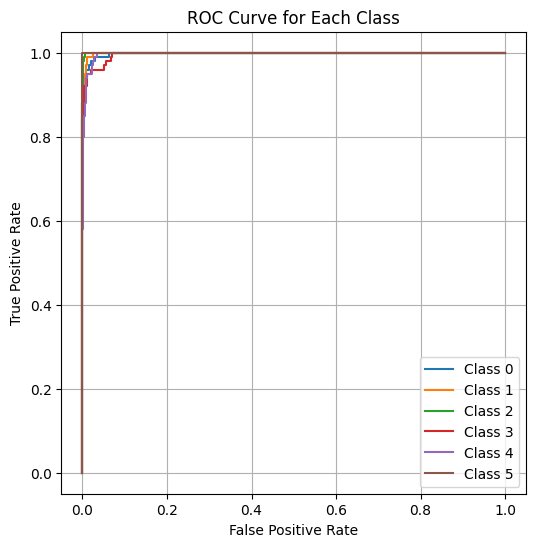

In [28]:
# calculate kappa score
kappa_cnn = cohen_kappa_score(true_labels,pred_labels)
print(f'kappa score : {kappa_cnn}')

# convert to Numpy arrays
pred_labels = np.array(pred_labels)
pred_prob = np.array(pred_prob)
true_labels = np.array(true_labels)

# generate ROC curve for each class
fpr = dict()
tpr = dict()

for i in range(6):
    # calculate false positive rate and true positive rate per class using roc_curve function
    # using one-vs-rest logic
    fpr[i], tpr[i], _ = roc_curve(true_labels == i, pred_prob[:, i])

plt.figure(figsize=(6, 6))
for i in range(6):
    plt.plot(fpr[i], tpr[i], label=f'Class {i}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate ResNet18

kappa score : 0.948


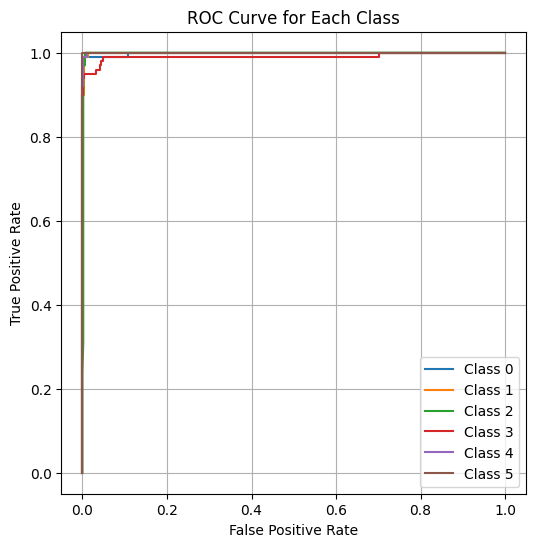

In [29]:
# calculate kappa score
kappa_resnet = cohen_kappa_score(true_labels_resnet,pred_labels_resnet)
print(f'kappa score : {kappa_resnet}')

# convert to Numpy arrays
pred_labels_resnet = np.array(pred_labels_resnet)
pred_prob_resnet = np.array(pred_prob_resnet)
true_labels_resnet = np.array(true_labels_resnet)

# generate ROC curve for each class
fpr_resnet = dict()
tpr_resnet = dict()

for i in range(6):
    # calculate false positive rate and true positive rate per class
    fpr_resnet[i], tpr_resnet[i], _ = roc_curve(true_labels_resnet == i, pred_prob_resnet[:, i])

plt.figure(figsize=(6, 6))

# plot ROC
for i in range(6):
    plt.plot(fpr_resnet[i], tpr_resnet[i], label=f'Class {i}')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend()
plt.grid(True)
plt.show()



# Observations

Both models appear to be very accurate, and all classes are highly separable from the rest.